<h1><center> ASDS 5303 Final Project Assignment #5 Dataset 1: Drug SMILES Strings and Classifications </center></h1>

## Group Members
### Henry Berrios #1001392315
### LeMaur Kydd #1001767382
### Group ID: BerKyd

# **Introduction & Dataset Overview**

## <ins>Dataset Description:</ins>
The SMILES Strings and Drug Classification dataset sourced from a [paper](https://doi.org/10.1021/acs.jcim.9b00236) is a compilation of a few different datasets, namely [PubChem](https://pubchem.ncbi.nlm.nih.gov/) and [ZINC](https://zinc.docking.org/). It contains SMILES Strings, which will function as the basis of our training data and drug classifications, which will be our target variable. There are 6 other chemical features that can help classification performance if necessary.

The features in the dataset are as follows:
- IsomericSMILES Strings
- De-salted SMILES Strings
- Drug Classification (Target)
- XLogP
- Molecular Weight
- CID (PubChem Molecular ID#)
- HBondAcceptorCount
- HBondDonorCount

## <ins>Defining the ML Problem</ins>
- Supervised Learning Task: Classification
- Modality: Text (character-based SMILES strings)
- Goal: Predict the Drug Classification of a given SMILES String using only the SMILES String data.
- Potential Use: Molecular structures can have their medicinal value estimated without costly lab research based on its SMILES String.
- Target variable: Drug Classification (categorical variable)
- Output Modeling: Model outputs class probabilties vias softmax and selects the class with the highest probability as prediction.
- Why It's Challenging: SMILES strings encode complex molecular structures as linear text, making it difficult for traditional models to interpret chemical meaning.  
- Why It Matters: Accurate predictions could accelerate drug discovery by reducing reliance on costly lab experiments through in-silico molecular screening.

In [ ]:
# importing libraries (same as previous assignments, partially filled by google colab autofill)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pandas as pd
import numpy as np
from scipy.io import wavfile
import time
import sys
sys.stdout.flush()

import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

from google.colab import drive

# **Implementing a 1D Convolutional Neural Network (CNN) for SMILES Data and Finalizing Architecture**

In [ ]:
# using cuda if we can
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# defining a 1D convolutional neural network for SMILES data (large portions of code are autofilled by google colab's gemini)
class SMILESCNN(nn.Module):
    def __init__(self, output_size):
        super(SMILESCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, output_size)

    def forward(self, x):
        # rearranging tensor dimensions for Conv1D: [batch_size, channels, seq_length()]
        x = x.permute(0, 2, 1)  # [batch, 128, 399]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

In [ ]:
# defining a training loop with early stopping and learning rate scheduling (large portions of code are autofilled by google colab's gemini)
def train_model(model, train_loader, test_loader, epochs=30, lr=0.001, patience=5, criterion=None, optimizer_type = "adam", momentum = 0.9):
    if optimizer_type == 'adam':
      optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
      optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd_momentum':
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum)
    else:
      raise ValueError("Invalid optimizer type. Choose 'adam', 'sgd', or 'sgd_momentum'.")
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
    train_losses, test_losses = [], []
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # evaluated on test data
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # printing results
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        sys.stdout.flush()

        scheduler.step(test_loss)

        # early stopping logic
        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, test_losses

In [ ]:
# function to evaluate model performance on the test set (large portions of code are autofilled by google colab's gemini)
def evaluate_model(model, test_loader):
  model.eval()
  y_true = []
  y_pred = []
  y_probs = []

  with torch.no_grad():
    for batch_x, batch_y in test_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      outputs = model(batch_x)
      _, predicted = torch.max(outputs, 1)

      y_true.extend(batch_y.argmax(dim = 1).cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())
      y_probs.extend(outputs.cpu().numpy())

    # computing eval metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average = 'weighted', zero_division = 0)
    recall = recall_score(y_true, y_pred, average = 'weighted', zero_division = 0)
    f1 = f1_score(y_true, y_pred, average = 'weighted', zero_division = 0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # printing results
    print(f"\Final Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy, precision, recall, f1, conf_matrix, y_true, y_pred, y_probs

In [ ]:
# misclassification table (large portions of code are autofilled by google colab's gemini)
def show_misclassification(y_true, y_pred):
  mis_df = pd.DataFrame({'True': y_true, 'Pred': y_pred})
  mis_df = mis_df[mis_df['True'] != mis_df['Pred']]
  mis_table = mis_df.value_counts().reset_index(name = 'Count')
  print("\nMisclassification Table:")
  print(mis_table)
  return mis_table

In [ ]:
# ROC curve plot (large portions of code are autofilled by google colab's gemini)
def plot_roc(y_true, y_probs, num_classes):
  y_true_bin = label_binarize(y_true, classes = np.arange(num_classes))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label = f'Class {i} (AUC = {roc_auc[i]:.2f})')

  # plot
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc = 'lower right')
  plt.grid(True)
  plt.show()

In [ ]:
# saliency map (large portions of code are autofilled by google colab's gemini)
def compute_saliency(model, input_tensor, target_class):
  model.eval()
  input_tensor = input_tensor.unsqueeze(0).clone().detach().requires_grad_(True)
  output = model(input_tensor)
  loss = output[0, target_class]
  model.zero_grad()
  loss.backward()

  # input tesnor has grad populated
  saliency = input_tensor.grad.abs().squeeze().cpu().numpy()
  salience = saliency.mean(axis = 1)

  # plot
  plt.figure(figsize = (10, 2))
  plt.plot(saliency)
  plt.title(f"Saliency Map for Target Class {target_class}")
  plt.xlabel("Token Position")
  plt.ylabel("Saliency Value")
  plt.grid(True)
  plt.show()

In [ ]:
# loading pre processed data
mounth_drive = '/content/drive'
drive.mount(mounth_drive)

X_train = torch.load('/content/drive/MyDrive/X_train_tensor_d1.pt').to(device)
X_test = torch.load('/content/drive/MyDrive/X_test_tensor_d1.pt').to(device)
y_train = torch.load('/content/drive/MyDrive/y_train_tensor_d1.pt').to(device)
y_test = torch.load('/content/drive/MyDrive/y_test_tensor_d1.pt').to(device)

# calculate class weights for imbalanced dataset
y_train_labels = torch.argmax(y_train, dim = 1).cpu().numpy()
class_counts = np.bincount(y_train_labels)
class_weights = 1.0 / class_counts
weights = torch.tensor(class_weights, dtype = torch.float32).to(device)

# set loss function with class weights
criterion = nn.CrossEntropyLoss(weight = weights)

Mounted at /content/drive


In [ ]:
# checking shape of tensors
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([5548, 399, 128])
torch.Size([5548, 5])
torch.Size([1387, 399, 128])
torch.Size([1387, 5])


In [ ]:
# setting batch size and creating DataLoaders for training and testing (large portions of code are autofilled by google colab's gemini)
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [ ]:
# intializing and training the CNN model (large portions of code are autofilled by google colab's gemini)
baseline_model = SMILESCNN(output_size=y_train.shape[1]).to(device)
start_time = time.time()
train_losses, test_losses = train_model(baseline_model, train_loader, test_loader, epochs=30, lr=0.001, patience=5, criterion=criterion, optimizer_type='adam')
end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds")

Epoch 1, Train Loss: 0.0015, Test Loss: 0.0012
Epoch 2, Train Loss: 0.0012, Test Loss: 0.0011
Epoch 3, Train Loss: 0.0011, Test Loss: 0.0010
Epoch 4, Train Loss: 0.0010, Test Loss: 0.0010
Epoch 5, Train Loss: 0.0010, Test Loss: 0.0009
Epoch 6, Train Loss: 0.0009, Test Loss: 0.0009
Epoch 7, Train Loss: 0.0009, Test Loss: 0.0009
Epoch 8, Train Loss: 0.0009, Test Loss: 0.0009
Epoch 9, Train Loss: 0.0008, Test Loss: 0.0009
Epoch 10, Train Loss: 0.0008, Test Loss: 0.0008
Epoch 11, Train Loss: 0.0008, Test Loss: 0.0008
Epoch 12, Train Loss: 0.0008, Test Loss: 0.0008
Epoch 13, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 14, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 15, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 16, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 17, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 18, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 19, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 20, Train Loss: 0.0006, Test Loss: 0.0008
Epoch 21, Train Loss: 0.0006, Test Loss: 0.0008
E

In [ ]:
# evaluating the model
evaluate_model(baseline_model, test_loader)

\Final Evaluation:
Accuracy: 0.7282
Precision: 0.7397
Recall: 0.7282
F1 Score: 0.7313
Confusion Matrix:
[[372  36  21  31  19]
 [ 11 179  11  14  20]
 [ 10   5 102  25  16]
 [  9  13  22 168  16]
 [ 22  25  23  28 189]]


(0.7281903388608507,
 0.7396955986085383,
 0.7281903388608507,
 0.7313315084085198,
 array([[372,  36,  21,  31,  19],
        [ 11, 179,  11,  14,  20],
        [ 10,   5, 102,  25,  16],
        [  9,  13,  22, 168,  16],
        [ 22,  25,  23,  28, 189]]),
 [np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(4),
  np.int64(3),
  np.int64(2),
  np.int64(0),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(1),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(3),
  np.int64(4),
  np.int64(1),
  np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(3),
  np.int64(1),
  np.int64(3),
  np.int64(0),
  np.int64(1),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(4),
  np.int64(1),
  np.int64(0),
  np.int64(2),
  np.int64(4),
  np.int64(1),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np

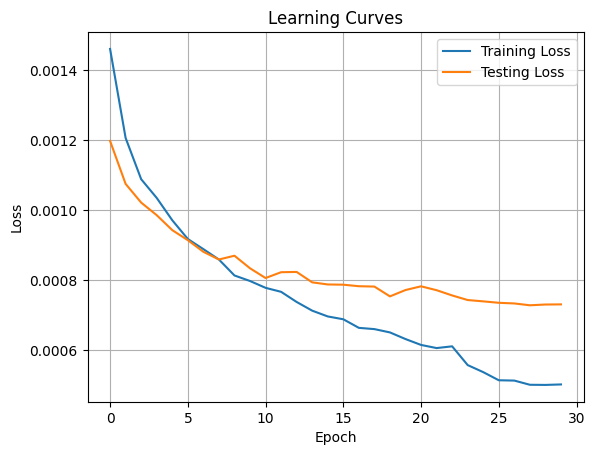

In [ ]:
# plotting training and testing loss curves
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.grid(True)
plt.show()

\Final Evaluation:
Accuracy: 0.7282
Precision: 0.7397
Recall: 0.7282
F1 Score: 0.7313
Confusion Matrix:
[[372  36  21  31  19]
 [ 11 179  11  14  20]
 [ 10   5 102  25  16]
 [  9  13  22 168  16]
 [ 22  25  23  28 189]]

Misclassification Table:
    True  Pred  Count
0      0     1     36
1      0     3     31
2      4     3     28
3      2     3     25
4      4     1     25
5      4     2     23
6      3     2     22
7      4     0     22
8      0     2     21
9      1     4     20
10     0     4     19
11     2     4     16
12     3     4     16
13     1     3     14
14     3     1     13
15     1     0     11
16     1     2     11
17     2     0     10
18     3     0      9
19     2     1      5


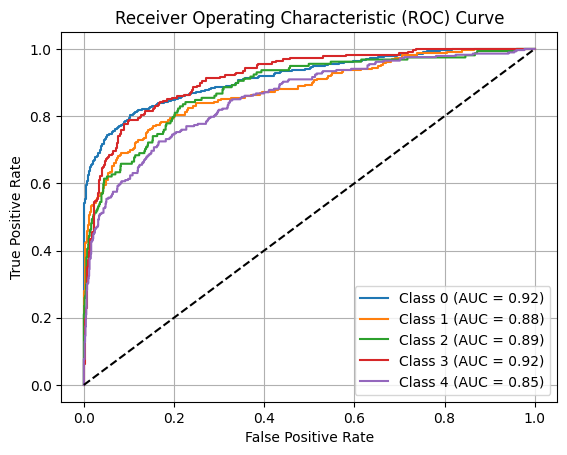

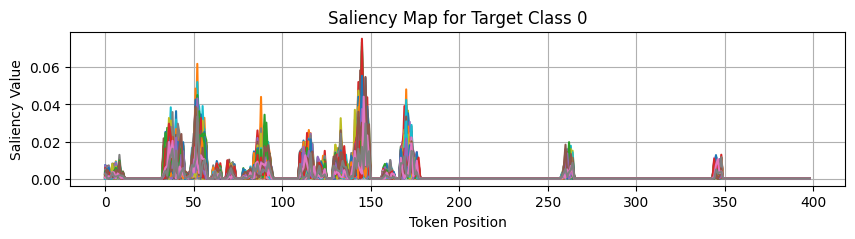

In [ ]:
# other plots (large portions of code are autofilled by google colab's gemini)
accuracy, precision, recall, f1, cm, y_true, y_pred, y_probs = evaluate_model(baseline_model, test_loader)
show_misclassification(y_true, y_pred)
plot_roc(y_true, y_probs, num_classes=5)
compute_saliency(baseline_model, X_test[0], target_class=np.argmax(y_test[0].cpu().numpy()))

# **Optimizing Network Depth and Width with Adam**

In [ ]:
# customizing CNN for SMILEs with different filters and kernel sizes (large portions of code are autofilled by google colab's gemini)
class TunableCNN(nn.Module):
    def __init__(self, output_size, num_filters = 256, kernel_size = 5, dropout_rate = 0.5):
        super(TunableCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 128, out_channels = num_filters, kernel_size = kernel_size, padding = kernel_size // 2)
        self.relu  = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

In [ ]:
# trying different CNN configs (large portions of code are autofilled by google colab's gemini)
filter_sizes = [64, 128, 256]
kernel_sizes = [3, 5, 7]
dropout_rates = [0.2, 0.3, 0.4]

best_loss = float("inf")
best_config = None
results = []

for f in filter_sizes:
  for k in kernel_sizes:
    for d in dropout_rates:
      print(f"Training model with filter size {f}, kernel size {k}, and dropout rate {d}")

      # intialize the model
      model = TunableCNN(output_size = y_train.shape[1], num_filters = f, kernel_size = k, dropout_rate = d).to(device)
      train_losses, test_losses = train_model(model, train_loader, test_loader, epochs = 20, lr = 0.001, criterion = criterion, optimizer_type='adam')

      #eval metrics
      accuracy, precision, recall, f1, conf_matrix, y_true, y_pred, y_probs = evaluate_model(model, test_loader)
      final_loss = test_losses[-1]
      results.append({'Filter Size': f,
                      'Kernel Size': k,
                      'Dropout Rate': d,
                      'Loss': final_loss,
                      'Accuracy': accuracy,
                      'Precision': precision,
                      'Recall': recall,
                      'F1': f1})

      # track best model
      if final_loss < best_loss:
        best_loss = final_loss
        best_config = (f, k, d)

      # clear gpu memory
      torch.cuda.empty_cache()

Training model with filter size 64, kernel size 3, and dropout rate 0.2
Epoch 1, Train Loss: 0.0014, Test Loss: 0.0013
Epoch 2, Train Loss: 0.0013, Test Loss: 0.0012
Epoch 3, Train Loss: 0.0012, Test Loss: 0.0012
Epoch 4, Train Loss: 0.0012, Test Loss: 0.0011
Epoch 5, Train Loss: 0.0011, Test Loss: 0.0011
Epoch 6, Train Loss: 0.0011, Test Loss: 0.0011
Epoch 7, Train Loss: 0.0011, Test Loss: 0.0010
Epoch 8, Train Loss: 0.0011, Test Loss: 0.0010
Epoch 9, Train Loss: 0.0010, Test Loss: 0.0010
Epoch 10, Train Loss: 0.0010, Test Loss: 0.0010
Epoch 11, Train Loss: 0.0010, Test Loss: 0.0010
Epoch 12, Train Loss: 0.0010, Test Loss: 0.0010
Epoch 13, Train Loss: 0.0010, Test Loss: 0.0010
Epoch 14, Train Loss: 0.0010, Test Loss: 0.0010
Epoch 15, Train Loss: 0.0009, Test Loss: 0.0010
Epoch 16, Train Loss: 0.0009, Test Loss: 0.0010
Epoch 17, Train Loss: 0.0009, Test Loss: 0.0009
Epoch 18, Train Loss: 0.0009, Test Loss: 0.0009
Epoch 19, Train Loss: 0.0009, Test Loss: 0.0009
Epoch 20, Train Loss: 0.0

In [ ]:
# evaluating the best CNN config (large portions of code are autofilled by google colab's gemini)
best_result = next(res for res in results if (
     res['Filter Size'] == best_config[0] and
     res['Kernel Size'] == best_config[1] and
     res['Dropout Rate'] == best_config[2]
 ))

# print best configuration and metrics
print(f"\nBest Configuration: {best_config}")
print(f"Filters: {best_result['Filter Size']}, Kernel Size: {best_result['Kernel Size']}, Dropout Rate: {best_result['Dropout Rate']}")
print(f"Loss: {best_result['Loss']:.4f}")
print(f"Accuracy: {best_result['Accuracy']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}")
print(f"Recall: {best_result['Recall']:.4f}")
print(f"F1: {best_result['F1']:.4f}")


Best Configuration: (256, 7, 0.3)
Filters: 256, Kernel Size: 7, Dropout Rate: 0.3
Loss: 0.0007
Accuracy: 0.7621
Precision: 0.7673
Recall: 0.7621
F1: 0.7632


Epoch 1, Train Loss: 0.0014, Test Loss: 0.0011
Epoch 2, Train Loss: 0.0011, Test Loss: 0.0010
Epoch 3, Train Loss: 0.0010, Test Loss: 0.0009
Epoch 4, Train Loss: 0.0008, Test Loss: 0.0009
Epoch 5, Train Loss: 0.0008, Test Loss: 0.0008
Epoch 6, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 7, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 8, Train Loss: 0.0006, Test Loss: 0.0007
Epoch 9, Train Loss: 0.0006, Test Loss: 0.0008
Epoch 10, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 11, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 12, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 13, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 14, Train Loss: 0.0004, Test Loss: 0.0007
Epoch 15, Train Loss: 0.0004, Test Loss: 0.0007
Epoch 16, Train Loss: 0.0004, Test Loss: 0.0007
Epoch 17, Train Loss: 0.0004, Test Loss: 0.0007
Epoch 18, Train Loss: 0.0004, Test Loss: 0.0007
Epoch 19, Train Loss: 0.0004, Test Loss: 0.0007
Epoch 20, Train Loss: 0.0003, Test Loss: 0.0007
\Final Evaluation:
Accuracy: 0.7484
Precision: 0.

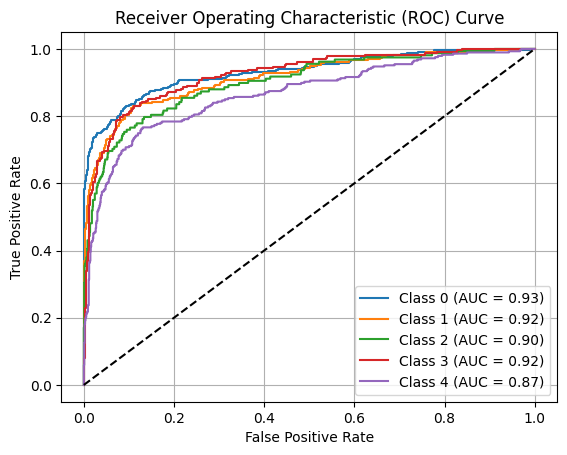

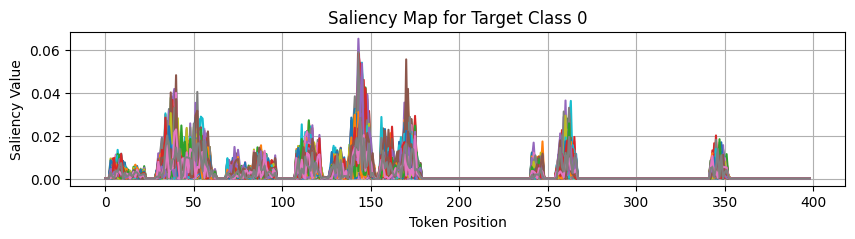


[Best Model Metrics]
Accuracy: 0.7484
Precision: 0.7630
Recall: 0.7484
F1 Score: 0.7518
Confusion Matris:
[[366  27  12  35  39]
 [ 13 176   6  16  24]
 [  5   5 106  24  18]
 [  7   9  15 181  16]
 [ 11  22  15  30 209]]


In [ ]:
# best model (large portions of code are autofilled by google colab's gemini)
best_model = TunableCNN(output_size = y_train.shape[1], num_filters = best_config[0], kernel_size = best_config[1], dropout_rate = best_config[2]).to(device)
_, _ = train_model(best_model, train_loader, test_loader, epochs = 20, lr = 0.001, criterion = criterion, optimizer_type='adam')

# eval final model
best_acc, best_prec, best_recall, best_f1, best_cm, best_y_true, best_y_pred, best_y_probs = evaluate_model(best_model, test_loader)
show_misclassification(best_y_true, best_y_pred)
plot_roc(best_y_true, best_y_probs, num_classes=5)
compute_saliency(best_model, X_test[0], target_class=np.argmax(y_test[0].cpu().numpy()))

# save best model
torch.save(best_model.state_dict(), '/content/drive/MyDrive/best_tunable_cnn.pth')

# print best model metrics
print("\n[Best Model Metrics]")
print(f"Accuracy: {best_acc:.4f}")
print(f"Precision: {best_prec:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1 Score: {best_f1:.4f}")
print(f"Confusion Matris:")
print(best_cm)

# **Stochastic Gradient Descent (SGD)**

In [ ]:
# top 3 best model configurations from adam test trial (large portions of code are autofilled by google colab's gemini)
model_configs = [
    (256, 7, 0.3), # Model A
    (256, 7, 0.2), # Model B
    (128, 7, 0.2) # Model C
]

# creating a list of batch sizes (full batch, 1/2, 1/4 and so on)
batch_size = [len(train_dataset) // (2 ** i) for i in range(3)]
sgd_results = []

In [ ]:
# trying with learning rate 0.01 (large portions of code are autofilled by google colab's gemini)

# looping over each batch size
for config_id, config in enumerate(model_configs):
  num_filters, kernel_size, dropout_rate = config

  for bs in batch_size:
    print(f"Training CNN model {chr(65 + config_id)} with batch size {bs}")

    # creating a DataLoader with the given batch size
    sgd_loader = DataLoader(train_dataset, batch_size = bs, shuffle = True)

    # intializing the model for each individual run
    sgd_model = TunableCNN(
        output_size = y_train.shape[1],
        num_filters = best_config[0],
        kernel_size = best_config[1],
        dropout_rate = best_config[2]
    ).to(device)

    # time it takes to train
    start_time = time.time()
    train_losses, test_losses = train_model(sgd_model, sgd_loader, test_loader, epochs = 15, lr = 0.01, criterion = criterion, optimizer_type='sgd')
    end_time = time.time()

    # evaluate the model and store the results
    sgd_time = end_time - start_time
    print(f"Training time: {sgd_time} seconds")
    accuracy, precision, recall, f1, conf_matrix, y_true, y_pred, y_probs = evaluate_model(sgd_model, test_loader)

    sgd_results.append({'Batch_size': bs,
                        'Training Time': sgd_time,
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'loss': test_losses[-1]})

    del sgd_model
    torch.cuda.empty_cache()


Training CNN model A with batch size 5548
Epoch 1, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 2, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 3, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 4, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 5, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 6, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 7, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 8, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 9, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 10, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 11, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 12, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 13, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 14, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 15, Train Loss: 0.0018, Test Loss: 0.0017
Training time: 291.00077629089355 seconds
\Final Evaluation:
Accuracy: 0.1132
Precision: 0.0129
Recall: 0.1132
F1 Score: 0.0232
Confusion Matrix:
[[  0   0 479   0   0]
 [  0   0 232   0   3]
 [  0   0 157   0   1]
 [  0   0 228   0   0]
 [  0   0

In [ ]:
# trying with learning rate 0.05 (large portions of code are autofilled by google colab's gemini)

# looping over each batch size
for config_id, config in enumerate(model_configs):
  num_filters, kernel_size, dropout_rate = config

  for bs in batch_size:
    print(f"Training CNN model {chr(65 + config_id)} with batch size {bs}")

    # creating a DataLoader with the given batch size
    sgd_loader = DataLoader(train_dataset, batch_size = bs, shuffle = True)

    # intializing the model for each individual run
    sgd_model = TunableCNN(
        output_size = y_train.shape[1],
        num_filters = best_config[0],
        kernel_size = best_config[1],
        dropout_rate = best_config[2]
    ).to(device)

    # time it takes to train
    start_time = time.time()
    train_losses, test_losses = train_model(sgd_model, sgd_loader, test_loader, epochs = 5, lr = 0.05, criterion = criterion, optimizer_type='sgd')
    end_time = time.time()

    # evaluate the model and store the results
    sgd_time = end_time - start_time
    print(f"Training time: {sgd_time} seconds")
    accuracy, precision, recall, f1, conf_matrix, y_true, y_pred, y_probs = evaluate_model(sgd_model, test_loader)

    sgd_results.append({'Batch_size': bs,
                        'Training Time': sgd_time,
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'loss': test_losses[-1]})

    del sgd_model
    torch.cuda.empty_cache()

Training CNN model A with batch size 5548
Epoch 1, Train Loss: 0.0021, Test Loss: 0.0021
Epoch 2, Train Loss: 0.0021, Test Loss: 0.0020
Epoch 3, Train Loss: 0.0021, Test Loss: 0.0020
Epoch 4, Train Loss: 0.0021, Test Loss: 0.0020
Epoch 5, Train Loss: 0.0021, Test Loss: 0.0020
Training time: 97.13633155822754 seconds
\Final Evaluation:
Accuracy: 0.3453
Precision: 0.1193
Recall: 0.3453
F1 Score: 0.1773
Confusion Matrix:
[[479   0   0   0   0]
 [235   0   0   0   0]
 [158   0   0   0   0]
 [228   0   0   0   0]
 [287   0   0   0   0]]
Training CNN model A with batch size 2774
Epoch 1, Train Loss: 0.0016, Test Loss: 0.0015
Epoch 2, Train Loss: 0.0015, Test Loss: 0.0015
Epoch 3, Train Loss: 0.0015, Test Loss: 0.0015
Epoch 4, Train Loss: 0.0016, Test Loss: 0.0015
Epoch 5, Train Loss: 0.0016, Test Loss: 0.0015
Training time: 101.15516090393066 seconds
\Final Evaluation:
Accuracy: 0.1759
Precision: 0.2101
Recall: 0.1759
F1 Score: 0.1623
Confusion Matrix:
[[ 65  70 220   0 124]
 [ 31  42 112   

# **SGD with Momentum**

In [ ]:
# top 3 best model configurations from adam test trial (large portions of code are autofilled by google colab's gemini)
model_configs = [
    (256, 7, 0.3), # Model A
    (256, 7, 0.2), # Model B
    (128, 7, 0.2) # Model C
]

# creating a list of batch sizes (full batch, 1/2, 1/4 and so on)
batch_size_list = [len(train_dataset) // (2 ** i) for i in range(3)]
momentum_results = []

In [ ]:
# various portions of this code block were filled in with autofill AI

# learning rate 0.05

# looping over batch sizes
for config_id, config in enumerate(model_configs):
  num_filters, kernel_size, dropout_rate = config
  for batch_size in batch_size_list:
    print(f"Training CNN model (SGD with Momentum) {chr(65 + config_id)} with batch size {batch_size}")

    loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    # creating new CNN model instance for each run
    model = SMILESCNN(output_size = y_train.shape[1]).to(device)

    # defining weighted loss
    criterion = nn.CrossEntropyLoss(weight = weights)

    # training time
    start_time = time.time()
    train_losses, test_losses = train_model(model, loader, test_loader, epochs = 10, lr = 0.05, criterion = criterion, optimizer_type= 'sgd_momentum')
    end_time = time.time()

    # printing results
    print(f"Batch Size: {batch_size}. Training Time: {end_time - start_time} seconds")

    # evaluating performance and accuracy
    accuracy, precision, recall, f1, conf_matrix, y_true, y_pred, y_probs = evaluate_model(model, test_loader)
    momentum_results.append({
        'Batch_size': batch_size,
        'Training Time': end_time - start_time,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
    })

    del model
    torch.cuda.empty_cache()

Training CNN model (SGD with Momentum) A with batch size 5548
Epoch 1, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 2, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 3, Train Loss: 0.0018, Test Loss: 0.0017
Epoch 4, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 5, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 6, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 7, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 8, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 9, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 10, Train Loss: 0.0018, Test Loss: 0.0016
Batch Size: 5548. Training Time: 193.904155254364 seconds
\Final Evaluation:
Accuracy: 0.1687
Precision: 0.0453
Recall: 0.1687
F1 Score: 0.0634
Confusion Matrix:
[[  0 443  36   0   0]
 [  0 216  19   0   0]
 [  0 140  18   0   0]
 [  0 205  23   0   0]
 [  0 257  30   0   0]]
Training CNN model (SGD with Momentum) A with batch size 2774
Epoch 1, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 2, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 3, Train Loss: 0.0018, Test

# Adam Batches

In [ ]:
# various portions of this code block were filled in with autofill AI

# learning rate 0.001

# looping over batch sizes
for config_id, config in enumerate(model_configs):
  num_filters, kernel_size, dropout_rate = config
  for batch_size in batch_size_list:
    print(f"Training CNN model (Adam) {chr(65 + config_id)} with batch size {batch_size}")

    loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    # creating new CNN model instance for each run
    model = SMILESCNN(output_size = y_train.shape[1]).to(device)

    # defining weighted loss
    criterion = nn.CrossEntropyLoss(weight = weights)

    # training time
    start_time = time.time()
    train_losses, test_losses = train_model(model, loader, test_loader, epochs = 10, lr = 0.0005, criterion = criterion, optimizer_type= 'adam')
    end_time = time.time()

    # printing results
    print(f"Batch Size: {batch_size}. Training Time: {end_time - start_time} seconds")

    # evaluating performance and accuracy
    accuracy, precision, recall, f1, conf_matrix, y_true, y_pred, y_probs = evaluate_model(model, test_loader)
    momentum_results.append({
        'Batch_size': batch_size,
        'Training Time': end_time - start_time,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
    })

    del model
    torch.cuda.empty_cache()

Training CNN model (Adam) A with batch size 5548
Epoch 1, Train Loss: 0.0017, Test Loss: 0.0014
Epoch 2, Train Loss: 0.0016, Test Loss: 0.0014
Epoch 3, Train Loss: 0.0016, Test Loss: 0.0014
Epoch 4, Train Loss: 0.0016, Test Loss: 0.0014
Epoch 5, Train Loss: 0.0015, Test Loss: 0.0013
Epoch 6, Train Loss: 0.0015, Test Loss: 0.0013
Epoch 7, Train Loss: 0.0015, Test Loss: 0.0013
Epoch 8, Train Loss: 0.0014, Test Loss: 0.0013
Epoch 9, Train Loss: 0.0014, Test Loss: 0.0013
Epoch 10, Train Loss: 0.0014, Test Loss: 0.0013
Batch Size: 5548. Training Time: 193.60854625701904 seconds
\Final Evaluation:
Accuracy: 0.4730
Precision: 0.5377
Recall: 0.4730
F1 Score: 0.4806
Confusion Matrix:
[[263 102  26  69  19]
 [ 23 130  10  57  15]
 [  8  25  37  66  22]
 [ 13  41  17 136  21]
 [ 26  59  19  93  90]]
Training CNN model (Adam) A with batch size 2774
Epoch 1, Train Loss: 0.0016, Test Loss: 0.0014
Epoch 2, Train Loss: 0.0015, Test Loss: 0.0014
Epoch 3, Train Loss: 0.0015, Test Loss: 0.0013
Epoch 4, T

# Post-Hoc Validation

In [ ]:
from typing_extensions import final

# (large portions of code are autofilled by google colab's gemini)

# post-hoc split of test set into val/test
X_val, X_final_test, y_val, y_final_test = train_test_split(X_test.cpu(), y_test.cpu(), test_size = 0.5, random_state = 42, stratify =y_test.cpu().argmax(dim = 1))

val_loader = DataLoader(TensorDataset(X_val.to(device), y_val.to(device)), batch_size = 128)
final_test_loader = DataLoader(TensorDataset(X_final_test.to(device), y_final_test.to(device)), batch_size = 128)

print("\n Validation Set Evaluation(post-hoc split)")
evaluate_model(best_model, val_loader)

print("\n Final Test Set Evaluation(post-hoc split)")
evaluate_model(best_model, final_test_loader)


 Validation Set Evaluation(post-hoc split)
\Final Evaluation:
Accuracy: 0.7417
Precision: 0.7551
Recall: 0.7417
F1 Score: 0.7446
Confusion Matrix:
[[182  10   5  22  20]
 [  8  83   5   7  15]
 [  3   3  52  15   6]
 [  6   3   9  91   5]
 [  8   9   7  13 106]]

 Final Test Set Evaluation(post-hoc split)
\Final Evaluation:
Accuracy: 0.7550
Precision: 0.7728
Recall: 0.7550
F1 Score: 0.7591
Confusion Matrix:
[[184  17   7  13  19]
 [  5  93   1   9   9]
 [  2   2  54   9  12]
 [  1   6   6  90  11]
 [  3  13   8  17 103]]


(0.7550432276657061,
 0.7727863119738354,
 0.7550432276657061,
 0.7590804605743352,
 array([[184,  17,   7,  13,  19],
        [  5,  93,   1,   9,   9],
        [  2,   2,  54,   9,  12],
        [  1,   6,   6,  90,  11],
        [  3,  13,   8,  17, 103]]),
 [np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(1),
  np.int64(1),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(1),
  np.int64(4),
  np.int64(4),
  np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(1),
  np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(4),
  np.int64(4),
  np.int64(1),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np

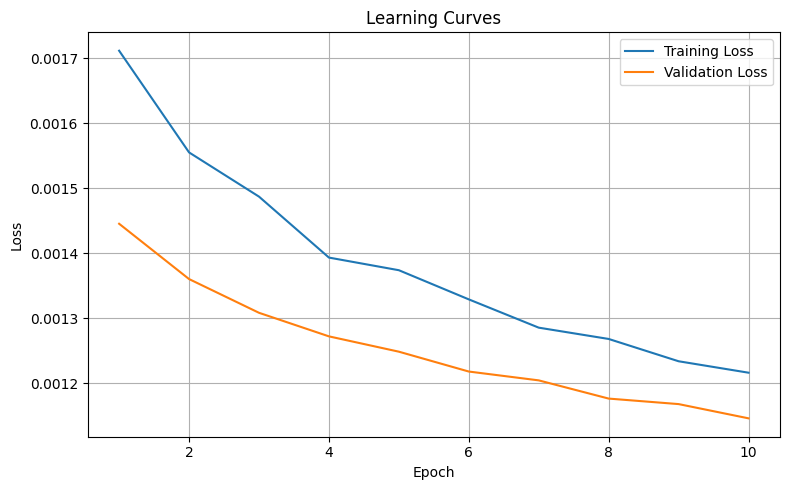

In [ ]:
# plotting learning curves (large portions of code are autofilled by google colab's gemini)
epochs = range(1, len(train_losses) + 1)


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()